# <center>  Report of TP2 </center>

### <center> IFT6758-A-A18 - Science des données </center>

#### Team Members
Qiang Ye (20139927), JinFang Luo(20111308), Lifeng Wan (20108546)

<hr>

## 1. Question 1 Competition of Classification

**Answer**

To accomplish the competition, we will train several simple residual convolutional neural networks on training dataset and verify their performance on validation dataset, which is split from the whole training dataset. Then, we will use these well trained networks to make prediction on the test dataset. Finally, we make an ensemble prediction using bagging. We save our final prediction in a csv file with each line has a integer 0 or 1 representing the class label of the respective example line in the test dataset.

### 1.1 GPU support on Colab.
Colab computation platform accelerates our training process.

In [1]:
# instruction of using colab python 
# https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x58792000 @  0x7fc70bc042a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [2]:
from google.colab import drive
drive.mount('/content/drive/')
# 4/oQAe5a98SL9kZzGrY2QyFGlcPFGy4wN4gZZ1O8R4y4zXhhJWJ0KnGT4

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
import os
os.chdir("drive/My Drive/Colab Notebooks/IFT6758/TP2/")
#check if you are in the right directory
!ls

 Codes_HW4_IFT6390_Final.ipynb
'IFT3700 et IFT6758 Automne 2018  Travail 2 francais.pdf'
 models
 PATCH.amat
 PATCH_test.amat
 qestion1.ipynb
 question1b.ipynb
 Report_TP2_20181220.ipynb
 Report_TP2_20181221.ipynb
 submission_bagging_models.csv
 submissions


### 1.2 modules

In [4]:
import numpy as np
from __future__ import print_function, division
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import copy
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from scipy.ndimage import rotate
import random

# use GPU as priority if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    use_cuda = True
else:
    device = torch.device('cpu')
    use_cuda = False
    
torch.set_default_tensor_type(torch.DoubleTensor)
print(device)

cuda


In [0]:
# We built two functions: `debug` and `print_progress` for debugging during 
# development and show training progress respectively.

DEBUG = True
def debug(*args, **kwargs):
    global DEBUG
    if DEBUG:
        print(*args, **kwargs)
        

def print_progress(i, time_elapsed = None, before = "progress:", after = ""):
    """show progress of process, often used in training a neural network model
    params
        i: progress value in [0, 1.], double
        time_elapsed: time elapsed from progress 0.0 to current progress, double
        before: descriptive content displayed before progress i, str
        after: descriptive content displayed after progress i, str
    """
    if time_elapsed is not None:
        if i >= 1:
            time_remaining = 0
        elif 0 < i < 1:
            time_remaining = time_elapsed * (1. - i) / i
        else:
            time_remaining = float('inf')
            
    progress_info = '{:>7.2%}'.format(i) # align right, 7 characters atmost
    if time_elapsed is not None:
        progress_info += ' {:.0f}m{:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60)
        if 0 < i < 1.0:
            progress_info += ' {:.0f}m{:.0f}s'.format(
                time_remaining // 60, time_remaining % 60)

    # display progress repeately in the same line.
    progress_info = '\r' + before + progress_info + after
    sys.stdout.flush()
    sys.stdout.write(progress_info)

In [0]:
# build two directories for saving model and submission files.
folders = ['./models', './submissions']
for i in range(len(folders)):
    if not os.path.exists(folders[i]):
        debug("creat")
        try:
            debug("creating folder: '{}'. ".format(folders[i]), end = "")
            os.mkdir(folders[i])
            debug("success.")
        except():
            debug("failure.")     

### 1.3 loading training data

In [0]:
data = np.loadtxt("PATCH.amat")

In [8]:
data.shape

(50000, 785)

We randomly display one example in the training dataset

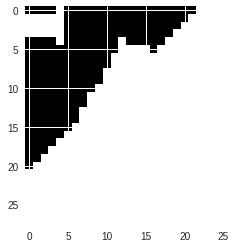

class: 0.0


In [9]:
id = random.randint(0, data.shape[0])
img = data[id,0:-1].reshape(28,28)
plt.imshow(img, cmap='gray')
plt.show()
print("class:",data[id,-1])

In [0]:
X, y = data[:,:-1], data[:,-1]

### 1.4 Building Models

We build a simple residual convolutional neural network `Net5` using pytorch.

In [0]:
class MyModule(nn.Module):
    def __init__(self, p_fc, p_conv, suffix):
        super(MyModule, self).__init__()
        self.dropout_p = p_fc
        self.dropout_conv_p = p_conv
        self.suffix = suffix

    def get_name(self, suffix = None):
        if suffix is not None:
            self.suffix = suffix
        name =  type(self).__name__ +  "_" + str(self.dropout_p) 
        name += "_" + str(self.dropout_conv_p) + "_" + str(suffix)
        return name
    
class Net5(MyModule):
    """CNN with best result"""
    def __init__(self, channels = [32, 64, 128, 128, 128],
                 p_fc = 0.0, p_conv = 0.0, hidden = 1000, suffix = ""):
        super(Net5, self).__init__(p_fc, p_conv, suffix)   
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride = 1, padding = 1)
        self.conv1_bn = nn.BatchNorm2d(channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride = 1,
                               padding = 1)
        self.conv2_bn = nn.BatchNorm2d(channels[1])
        
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, padding = 1)
        self.conv3_bn = nn.BatchNorm2d(channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3)
        self.conv4_bn = nn.BatchNorm2d(channels[3])
        self.conv5 = nn.Conv2d(channels[3], channels[4], 3)
        self.conv5_bn = nn.BatchNorm2d(channels[4])
        
        self.relu = nn.ReLU(inplace = True)
        self.fc1 = nn.Linear(channels[4]*4*4, hidden)
        self.fc_drop = nn.Dropout(p = self.dropout_p)
        self.fc2 = nn.Linear(hidden, n_class)
        
        
    def forward(self, x):                             # 1    28   28
        shortcut = x
        x = self.conv1_bn(self.relu(self.conv1(x)))   #31    28   28
        x = self.conv2_bn(self.relu(self.conv2(x)))   #64    28   28 

        x += shortcut                                 #shortcut
        
        x = self.conv3_bn(self.relu(self.conv3(x)))   #128   28   28  
        x = self.maxpool(x)                           #128   14   14
        
        x = self.conv4_bn(self.relu(self.conv4(x)))   #128   12   12         
        x = self.maxpool(x)                           #128    6    6 
        
        x = self.conv5_bn(self.relu(self.conv5(x)))   #128    4    4
            
        x = x.view(x.size(0), -1) # batch, 128
        x = self.fc_drop(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x    

### 1.5 Training Model

Before training the model, we implemented a method to load batch data from the datasets.

In [12]:
def dataloader(phase, data_source, 
               n_valid_sample = 1000, 
               batch_size = 128, 
               img_size = (30, 30)):
    """feed data to a training process with batch_size from a dataset
    params
        phase: decide whether the model is in 'train', 'val' or 'test'
        data_source: dataset np.array (sample_size, n_features)
        n_valid_sample: sample numbers for validating, int
        batch_size: int
        img_size: tuple, default (30, 30)
    return Iterable()
    """
    
    class Iterable(object):
        def __iter__(self):
            
            train_end = len(data_source) - n_valid_sample
            # use image size to compute number of features, some data_source may
            # not have the label(last column)
            n_feature = img_size[0] * img_size[1]
            
            if phase == 'train':
                data = data_source[ : train_end, :]
                #np.random.shuffle(data) # shuffle in subset
            elif phase == 'val':
                data = data_source[train_end : , :]
            else: # test dataset, no label column
                data = data_source
            
            inputs = data[:,:n_feature]
            if phase in ['train', 'val']: # have labels
                labels = data[:, -1]
            
            sample_size = inputs.shape[0]
            batches = int(np.ceil(sample_size / batch_size))
            #debug(batches)
            for j in range(batches):
                #debug("{} in dataloader".format(j))
                b_start = j * batch_size
                b_end = min(sample_size, (j + 1) * batch_size)
                
                batch_inputs = inputs[b_start:b_end, :]
                batch_inputs = torch.from_numpy(batch_inputs)
                batch_inputs = torch.unsqueeze(batch_inputs.view(
                    b_end-b_start, img_size[0], img_size[1]), dim = 1)
                
                if phase in ['train', 'val']:
                    batch_labels = labels[b_start:b_end]
                    batch_labels = torch.from_numpy(batch_labels)
                    batch_labels = batch_labels.type(torch.LongTensor)
                    yield batch_inputs, batch_labels
                else:
                    yield batch_inputs
    return Iterable()

debug(dataloader)

<function dataloader at 0x7f9832c76158>


We implemented a method `show_learning_curve` to plot the learning curve after training is finished.

In [0]:
def show_learning_curve(losses, accuracies):
    support = np.arange(len(losses['train']))
    plt.figure(figsize = (14, 6))
    plt.grid(True) # add a grid

    plt.subplot(1,2,1)
    plt.plot(support, losses['train'], 'g-', label = 'train')
    plt.plot(support, losses['val'], 'b-', label = 'val')
    plt.xlabel('epochs')
    plt.ylabel('losses')
    plt.title("Loss curves")
    plt.legend(loc='upper right')
    
    plt.subplot(1,2,2)
    plt.plot(support, accuracies['train'], 'g-', label = 'train' )
    plt.plot(support, accuracies['val'], 'b-', label = 'val')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title("Accuracy curves")
    plt.legend(loc='lower right')
    plt.show()

The following method `train_model` is the core method where forward propagation, backward propagation, and parameters update is performed. It receives several parameters to control the training procedure.

In [14]:
def train_model(model, 
                train_valid_set,
                criterion, 
                optimizer, 
                n_valid_sample,
                scheduler = None, 
                auto_save_path = './models/auto_save.model',
                best_model_path = './models/best_model_',
                max_epochs = 20, 
                early_stopping = False, 
                epoch_patience = 5,
                auto_load_best_after_train = True,
                auto_save_interval = 1,
                batch_size = 128,
                show_live_progress = False
                ):
    """train a model
    params
        model: to be trained, nn.Module
        train_valid_set: merge of training and validating set
        optimizer: optimizer
        n_valid_sample: number of validating samples
        scheduler: learning rate scheduler
        auto_save_path: path where latest model will be auto saved
        best_model_path: path where best model will be saved
        max_epochs: max epochs, int
        early_stopping: if trainint will stop earlier, according to accuracy on 
            validating dataset, Bool
        epoch_patience: if accuracy on validate set decreases, we don't stop
            at the epoch, we need to go extra epoch_patience number of epoch
            to confirm this decreasing trends, int
        auto_load_best_after_train: whether we load our best model paramters
            after the training process is complete, Bool
        auto_save_interval: the interval we auto save the parameters of the 
            model, int
        batch_size: batch_size, int      
    returns
        model: trained, nn.Module
        losses: losses during training and validating, 
            dict {"train", [double], 'val': [double]}
        accuracies: accuracies during training and validating, 
            dict {"train", [double], 'val': [double]}
        cache: a cache dict {'best_model_wts':best_model_wts,
                             'best_acc_val':best_acc_val,
                             'optimizer':optimizer,
                             'model':model
                            }
    """
    if train_valid_set is None:    # no data to train
        return model
    
    start = time.time()
    dataset_sizes = {
        'train': len(train_valid_set) - n_valid_sample,
        'val': n_valid_sample
    }
    
    dataloaders = {
        'train':dataloader('train', 
                           data_source = train_valid_set, 
                           n_valid_sample = n_valid_sample,
                           batch_size = batch_size, 
                           img_size = NEW_IMG_SIZE), 
        'val':dataloader('val', 
                         data_source = train_valid_set,
                         n_valid_sample = n_valid_sample,
                         batch_size = batch_size, 
                         img_size = NEW_IMG_SIZE)
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())  # for best parameters
    best_acc = {'train':0.0, 'val':0.0}                 # best accuracy
    
    losses = {'train': [], 'val':[]}
    accuracies = {'train': [], 'val':[]}
    patience_used = 0                                   # patience used
    early_stopped = 0
    debug("'s': auto saved, '*': best accuracy so far.")
    
    for epoch in range(max_epochs):
        since = time.time()
        
        # s_before and s_after are for print trainig progress
        s_before = '[Epoch{:>3d}/{} '.format(epoch, max_epochs - 1)
        s_after = ']'
        if show_live_progress:
            print_progress(0, 0, s_before, s_after)
        else:
            print(s_before + s_after, end = "")

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            since_phase = time.time()
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_size = 0
            if show_live_progress:
                print_progress(0, 0, s_before, s_after)
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, dim = 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # accumulate loss and correctly predicted sample number
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.data == labels.data).item()
                running_size += preds.size(0)
                
                if show_live_progress:
                    time_elapsed = time.time() - since_phase
                    print_progress(running_size/dataset_sizes[phase], 
                                   time_elapsed, 
                                   s_before, 
                                   s_after)
                    already_show_estimated_time = True
                # end batches loop
                
            # compute average loss and accuracy after a traing or validate phase
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # keep current loss and accuracy data
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            
            time_elapsed = time.time() - since_phase
            s_after += ' {} loss: {:.4f} acc: {:<7.2%} '.format(
                phase, epoch_loss, epoch_acc)
            

            # check current parameters achieved best performance so far
            # if YES, keep a reference to the best parameters.
            if epoch_acc > best_acc[phase]:
                best_acc[phase] = epoch_acc
                if phase == 'val':
                    s_after += " *"
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience_used = 0
            else:
                if phase == 'val': # avoid repeating check for both training
                                   # and validating phase
                    patience_used += 1 # 
                    if early_stopping and patience_used >= epoch_patience:
                        # patience is used up
                        early_stopped = epoch - epoch_patience + 1
                        
            if show_live_progress:
                print_progress(running_size/dataset_sizes[phase], 
                               time_elapsed, s_before, s_after)
            else:
                print(' {} loss: {:.4f} acc: {:<7.2%} '.format(
                    phase, epoch_loss, epoch_acc), end = " ")                        
            #end phase loop
    
        time_elapsed = time.time() - since
        if show_live_progress:
            print_progress(1, time_elapsed, s_before, s_after)
        else:
            print(' {:.0f}m{:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60), end = "")
        # display some information
        #if epoch_acc == best_acc['val']:
        #    print("*", end="")
        #else:
        #    print("", end="")
        if early_stopped or epoch == (max_epochs - 1) or \
           (epoch + 1) % auto_save_interval == 0:

            torch.save(model.state_dict(), auto_save_path)
            torch.save(best_model_wts, best_model_path)
            print(" s") # saved
        else:
            print("") # new line

        if early_stopped > 0:
            print("Early stop at epoch: {}".format(early_stopped))
            break
        #end epoch loop 
    
    
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        
    print('Best val Acc on val:   {:.2%}'.format(best_acc['val']))
    print('Best val Acc on train: {:.2%}'.format(best_acc['train']))
    # load best model weights
    
    if auto_load_best_after_train:
        model.load_state_dict(best_model_wts)
        
    train_info = {
        "best_acc_train": best_acc["train"],
        "best_acc_val": best_acc["val"],
        "time_elapsed": time_elapsed,
        "early_stopped": early_stopped,
        "epoch_passed": epoch + 1
    }
    return model, losses, accuracies, train_info

debug(train_model)

<function train_model at 0x7f987a5f8f28>


In the following cell, we create some instances of `Net5`,  set the training control parameters, split training dataset to training and validating dataset, and train the models. We will train 12 `Net5` models. All trained models will be saved to 2 files: one stores the latest parameters, and the other stores the parameters with which the model performs best on validating dataset.

global training configuration: 
('n_min_valid_set', 128)
('n_test_set', 5000)
('shuffle_before_split', True)
('use_norm', True)
('batch_size', 128)
('trainer', 'YQ')
('max_epochs', 30)
('early_stopping', True)
('epoch_patience', 5)
('auto_load_best_after_train', True)
('auto_save_interval', 5)
('show_live_progress', True)
reserve 5000 samples for testing

================== model0: Net5 ================== 
training model: Net5_0.5_0.0__YQ_0, lr: 0.001, weight_decay:0
shuffling train_valid_set before splitting... complete.
split train_valid_set to 40000 / 5000 samples
train_set size:40000, valid_set size:5000
's': auto saved, '*': best accuracy so far.
[Epoch  0/29 100.00% 0m49s] train loss: 0.2164 acc: 91.36%   val loss: 0.0968 acc: 97.16%   *
[Epoch  1/29 100.00% 0m49s] train loss: 0.0945 acc: 97.18%   val loss: 0.0677 acc: 97.90%   *
[Epoch  2/29 100.00% 0m49s] train loss: 0.0686 acc: 98.09%   val loss: 0.0682 acc: 98.18%   *
[Epoch  3/29 100.00% 0m49s] train loss: 0.0547 acc: 98.59%

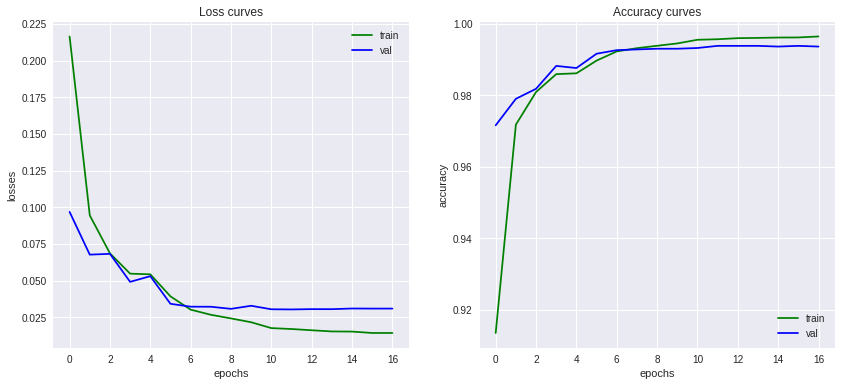

('n_min_valid_set', 128)
('n_test_set', 5000)
('shuffle_before_split', True)
('use_norm', True)
('batch_size', 128)
('trainer', 'YQ')
('max_epochs', 30)
('early_stopping', True)
('epoch_patience', 5)
('auto_load_best_after_train', True)
('auto_save_interval', 5)
('show_live_progress', True)
('best_acc_train', 0.996425)
('best_acc_val', 0.9938)
('time_elapsed', 838.4093170166016)
('early_stopped', 12)
('epoch_passed', 17)

================== model1: Net5 ================== 
training model: Net5_0.5_0.0__YQ_1, lr: 0.001, weight_decay:0
shuffling train_valid_set before splitting... complete.
split train_valid_set to 40000 / 5000 samples
train_set size:40000, valid_set size:5000
's': auto saved, '*': best accuracy so far.
[Epoch  0/29 100.00% 0m50s] train loss: 0.2357 acc: 90.30%   val loss: 0.1130 acc: 96.36%   *
[Epoch  1/29 100.00% 0m49s] train loss: 0.1029 acc: 96.77%   val loss: 0.0869 acc: 97.46%   *
[Epoch  2/29 100.00% 0m49s] train loss: 0.0774 acc: 97.86%   val loss: 0.0600 acc: 9

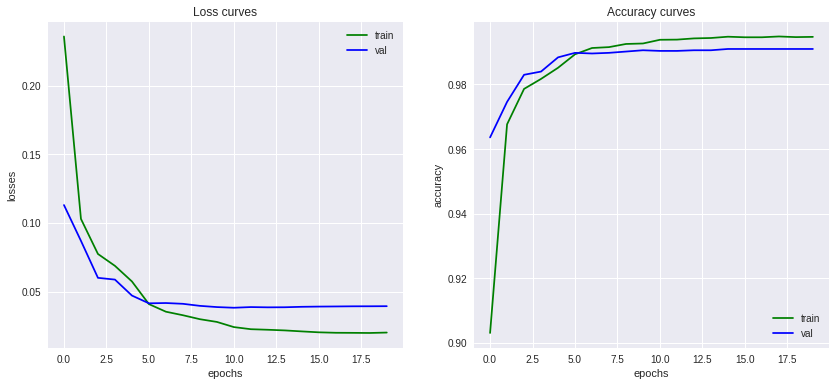

('n_min_valid_set', 128)
('n_test_set', 5000)
('shuffle_before_split', True)
('use_norm', True)
('batch_size', 128)
('trainer', 'YQ')
('max_epochs', 30)
('early_stopping', True)
('epoch_patience', 5)
('auto_load_best_after_train', True)
('auto_save_interval', 5)
('show_live_progress', True)
('best_acc_train', 0.994875)
('best_acc_val', 0.991)
('time_elapsed', 986.5288460254669)
('early_stopped', 15)
('epoch_passed', 20)

================== model2: Net5 ================== 
training model: Net5_0.5_0.0__YQ_2, lr: 0.001, weight_decay:0
shuffling train_valid_set before splitting... complete.
split train_valid_set to 40000 / 5000 samples
train_set size:40000, valid_set size:5000
's': auto saved, '*': best accuracy so far.
[Epoch  0/29 100.00% 0m50s] train loss: 0.2229 acc: 90.78%   val loss: 0.1429 acc: 95.04%   *
[Epoch  1/29 100.00% 0m50s] train loss: 0.0919 acc: 97.16%   val loss: 0.0718 acc: 97.82%   *
[Epoch  2/29 100.00% 0m49s] train loss: 0.0696 acc: 98.05%   val loss: 0.0600 acc: 98

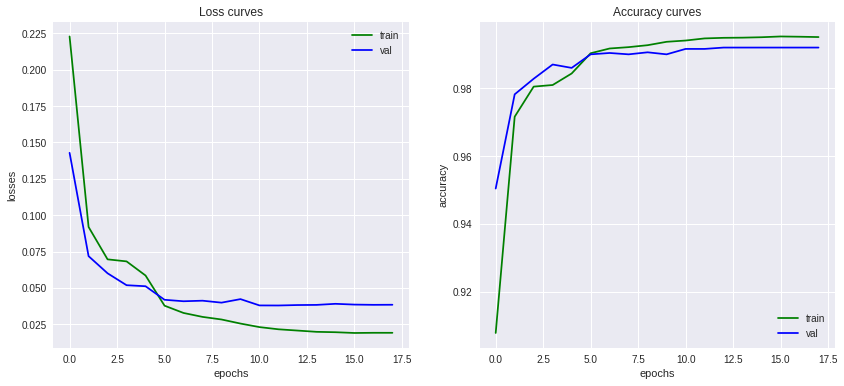

('n_min_valid_set', 128)
('n_test_set', 5000)
('shuffle_before_split', True)
('use_norm', True)
('batch_size', 128)
('trainer', 'YQ')
('max_epochs', 30)
('early_stopping', True)
('epoch_patience', 5)
('auto_load_best_after_train', True)
('auto_save_interval', 5)
('show_live_progress', True)
('best_acc_train', 0.995275)
('best_acc_val', 0.992)
('time_elapsed', 890.9551587104797)
('early_stopped', 13)
('epoch_passed', 18)

================== model3: Net5 ================== 
training model: Net5_0.5_0.0__YQ_3, lr: 0.001, weight_decay:0
shuffling train_valid_set before splitting... complete.
split train_valid_set to 40000 / 5000 samples
train_set size:40000, valid_set size:5000
's': auto saved, '*': best accuracy so far.
[Epoch  0/29 100.00% 0m50s] train loss: 0.2409 acc: 90.14%   val loss: 0.2778 acc: 89.00%   *
[Epoch  1/29 100.00% 0m49s] train loss: 0.1100 acc: 96.57%   val loss: 0.0950 acc: 97.32%   *
[Epoch  2/29 100.00% 0m49s] train loss: 0.0859 acc: 97.54%   val loss: 0.0828 acc: 97

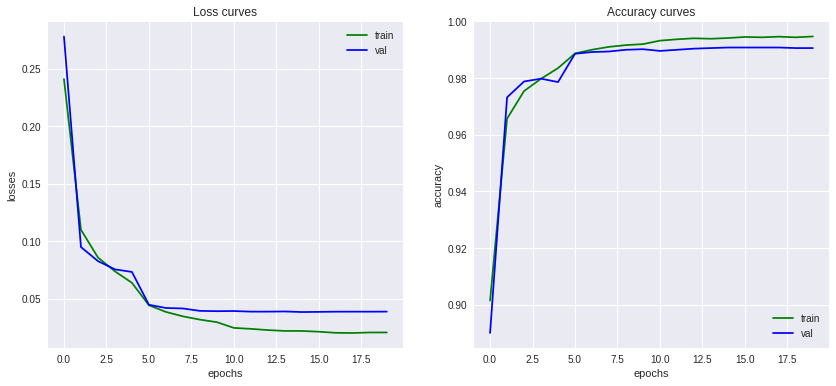

('n_min_valid_set', 128)
('n_test_set', 5000)
('shuffle_before_split', True)
('use_norm', True)
('batch_size', 128)
('trainer', 'YQ')
('max_epochs', 30)
('early_stopping', True)
('epoch_patience', 5)
('auto_load_best_after_train', True)
('auto_save_interval', 5)
('show_live_progress', True)
('best_acc_train', 0.9947)
('best_acc_val', 0.9908)
('time_elapsed', 985.8478403091431)
('early_stopped', 15)
('epoch_passed', 20)

================== model4: Net5 ================== 
training model: Net5_0.5_0.0__YQ_4, lr: 0.001, weight_decay:0
shuffling train_valid_set before splitting... complete.
split train_valid_set to 40000 / 5000 samples
train_set size:40000, valid_set size:5000
's': auto saved, '*': best accuracy so far.
[Epoch  0/29 100.00% 0m50s] train loss: 0.2249 acc: 90.81%   val loss: 0.1081 acc: 96.54%   *
[Epoch  1/29 100.00% 0m50s] train loss: 0.0944 acc: 97.11%   val loss: 0.0808 acc: 97.96%   *
[Epoch  2/29 100.00% 0m50s] train loss: 0.0751 acc: 97.99%   val loss: 0.0654 acc: 98.

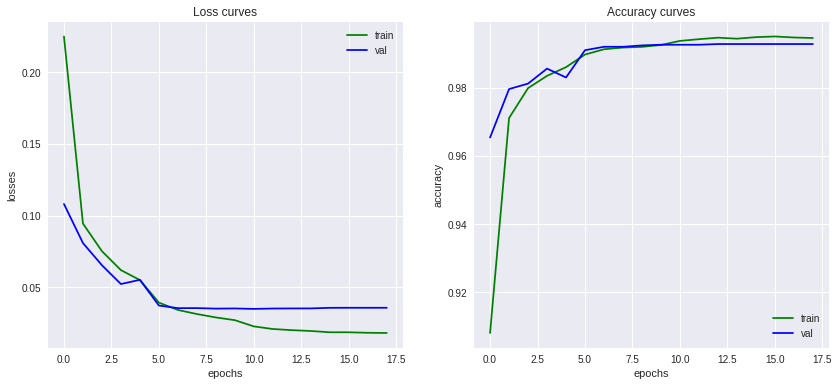

('n_min_valid_set', 128)
('n_test_set', 5000)
('shuffle_before_split', True)
('use_norm', True)
('batch_size', 128)
('trainer', 'YQ')
('max_epochs', 30)
('early_stopping', True)
('epoch_patience', 5)
('auto_load_best_after_train', True)
('auto_save_interval', 5)
('show_live_progress', True)
('best_acc_train', 0.995025)
('best_acc_val', 0.9928)
('time_elapsed', 890.7223167419434)
('early_stopped', 13)
('epoch_passed', 18)

================== model5: Net5 ================== 
training model: Net5_0.5_0.0__YQ_5, lr: 0.001, weight_decay:0
shuffling train_valid_set before splitting... complete.
split train_valid_set to 40000 / 5000 samples
train_set size:40000, valid_set size:5000
's': auto saved, '*': best accuracy so far.
[Epoch  0/29 100.00% 0m50s] train loss: 0.2139 acc: 91.40%   val loss: 0.1121 acc: 96.10%   *
[Epoch  1/29 100.00% 0m49s] train loss: 0.0865 acc: 97.50%   val loss: 0.0567 acc: 98.34%   *
[Epoch  2/29 100.00% 0m49s] train loss: 0.0663 acc: 98.19%   val loss: 0.0536 acc: 9

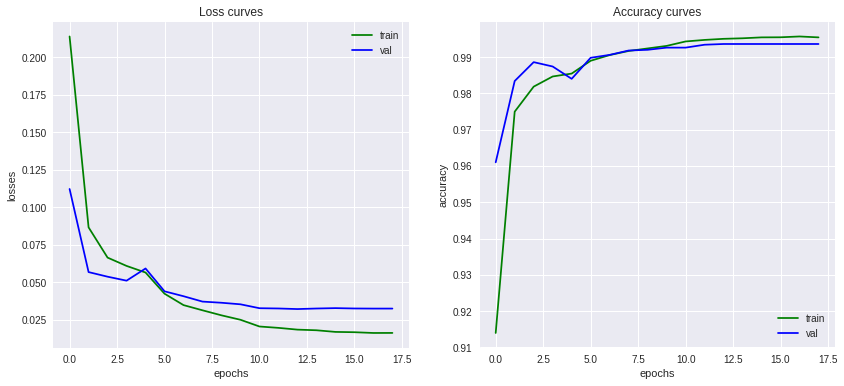

('n_min_valid_set', 128)
('n_test_set', 5000)
('shuffle_before_split', True)
('use_norm', True)
('batch_size', 128)
('trainer', 'YQ')
('max_epochs', 30)
('early_stopping', True)
('epoch_patience', 5)
('auto_load_best_after_train', True)
('auto_save_interval', 5)
('show_live_progress', True)
('best_acc_train', 0.995675)
('best_acc_val', 0.9936)
('time_elapsed', 890.0589621067047)
('early_stopped', 13)
('epoch_passed', 18)

================== model6: Net5 ================== 
training model: Net5_0.5_0.0__YQ_6, lr: 0.001, weight_decay:0
shuffling train_valid_set before splitting... complete.
split train_valid_set to 40000 / 5000 samples
train_set size:40000, valid_set size:5000
's': auto saved, '*': best accuracy so far.
[Epoch  0/29 100.00% 0m50s] train loss: 0.2135 acc: 91.36%   val loss: 0.1435 acc: 95.08%   *
[Epoch  1/29 100.00% 0m49s] train loss: 0.0908 acc: 97.21%   val loss: 0.0906 acc: 97.42%   *
[Epoch  2/29 100.00% 0m49s] train loss: 0.0716 acc: 98.02%   val loss: 0.0800 acc: 9

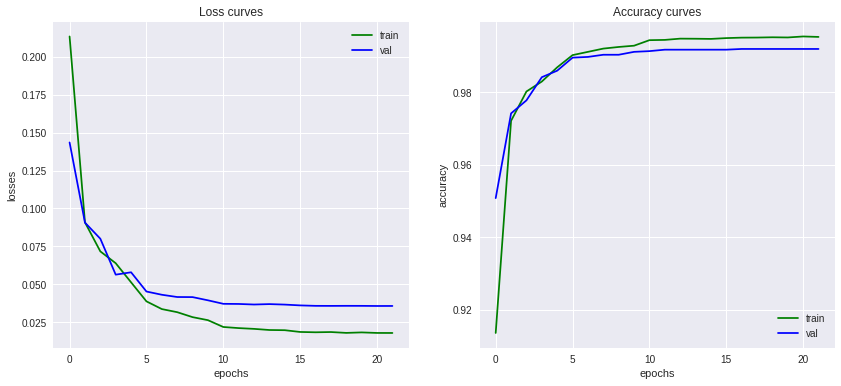

('n_min_valid_set', 128)
('n_test_set', 5000)
('shuffle_before_split', True)
('use_norm', True)
('batch_size', 128)
('trainer', 'YQ')
('max_epochs', 30)
('early_stopping', True)
('epoch_patience', 5)
('auto_load_best_after_train', True)
('auto_save_interval', 5)
('show_live_progress', True)
('best_acc_train', 0.99545)
('best_acc_val', 0.992)
('time_elapsed', 1084.934482574463)
('early_stopped', 17)
('epoch_passed', 22)

================== model7: Net5 ================== 
training model: Net5_0.5_0.0__YQ_7, lr: 0.001, weight_decay:0
shuffling train_valid_set before splitting... complete.
split train_valid_set to 40000 / 5000 samples
train_set size:40000, valid_set size:5000
's': auto saved, '*': best accuracy so far.
[Epoch  0/29 100.00% 0m50s] train loss: 0.2448 acc: 89.83%   val loss: 0.1191 acc: 95.90%   *
[Epoch  1/29 100.00% 0m50s] train loss: 0.1056 acc: 96.73%   val loss: 0.0703 acc: 98.12%   *
[Epoch  2/29 100.00% 0m49s] train loss: 0.0752 acc: 98.01%   val loss: 0.0709 acc: 98.

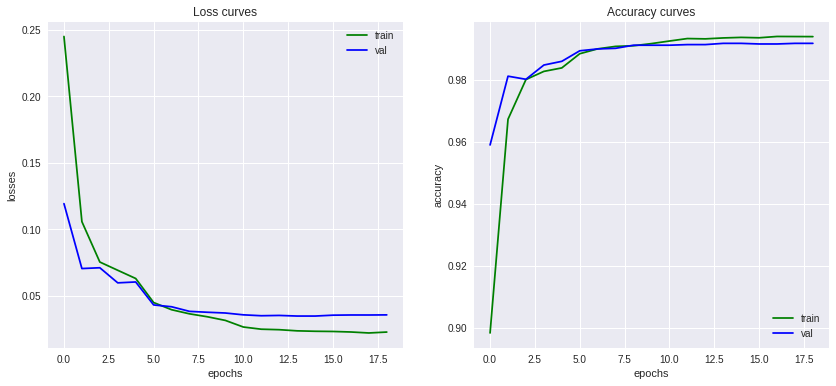

('n_min_valid_set', 128)
('n_test_set', 5000)
('shuffle_before_split', True)
('use_norm', True)
('batch_size', 128)
('trainer', 'YQ')
('max_epochs', 30)
('early_stopping', True)
('epoch_patience', 5)
('auto_load_best_after_train', True)
('auto_save_interval', 5)
('show_live_progress', True)
('best_acc_train', 0.994025)
('best_acc_val', 0.9918)
('time_elapsed', 940.0208373069763)
('early_stopped', 14)
('epoch_passed', 19)

================== model8: Net5 ================== 
training model: Net5_0.5_0.0__YQ_8, lr: 0.001, weight_decay:0
shuffling train_valid_set before splitting... complete.
split train_valid_set to 40000 / 5000 samples
train_set size:40000, valid_set size:5000
's': auto saved, '*': best accuracy so far.
[Epoch  0/29 100.00% 0m50s] train loss: 0.2360 acc: 90.21%   val loss: 0.1054 acc: 96.54%   *
[Epoch  1/29 100.00% 0m50s] train loss: 0.0989 acc: 96.97%   val loss: 0.0812 acc: 97.30%   *
[Epoch  2/29 100.00% 0m49s] train loss: 0.0711 acc: 98.08%   val loss: 0.0684 acc: 9

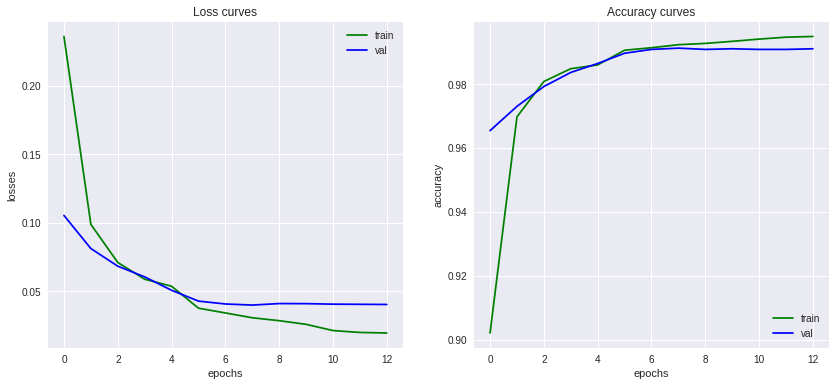

('n_min_valid_set', 128)
('n_test_set', 5000)
('shuffle_before_split', True)
('use_norm', True)
('batch_size', 128)
('trainer', 'YQ')
('max_epochs', 30)
('early_stopping', True)
('epoch_patience', 5)
('auto_load_best_after_train', True)
('auto_save_interval', 5)
('show_live_progress', True)
('best_acc_train', 0.99485)
('best_acc_val', 0.9912)
('time_elapsed', 642.8020238876343)
('early_stopped', 8)
('epoch_passed', 13)

================== model9: Net5 ================== 
training model: Net5_0.5_0.0__YQ_9, lr: 0.001, weight_decay:0
shuffling train_valid_set before splitting... complete.
split train_valid_set to 40000 / 5000 samples
train_set size:40000, valid_set size:5000
's': auto saved, '*': best accuracy so far.
[Epoch  0/29 100.00% 0m50s] train loss: 0.2336 acc: 90.34%   val loss: 0.1149 acc: 95.98%   *
[Epoch  1/29 100.00% 0m49s] train loss: 0.0956 acc: 97.04%   val loss: 0.0851 acc: 97.24%   *
[Epoch  2/29 100.00% 0m49s] train loss: 0.0772 acc: 97.76%   val loss: 0.0583 acc: 98.

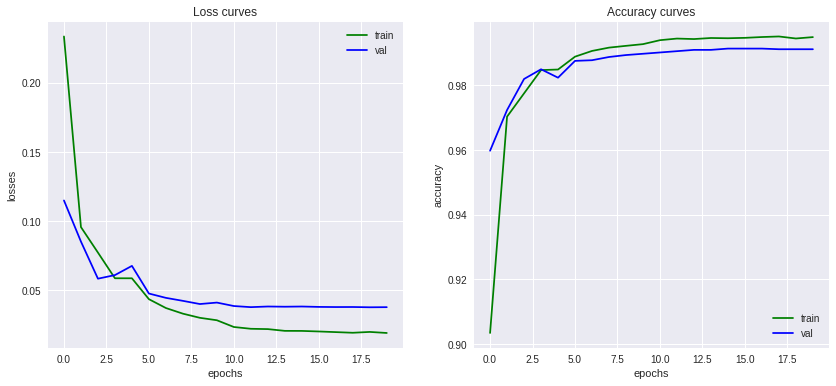

('n_min_valid_set', 128)
('n_test_set', 5000)
('shuffle_before_split', True)
('use_norm', True)
('batch_size', 128)
('trainer', 'YQ')
('max_epochs', 30)
('early_stopping', True)
('epoch_patience', 5)
('auto_load_best_after_train', True)
('auto_save_interval', 5)
('show_live_progress', True)
('best_acc_train', 0.99515)
('best_acc_val', 0.9914)
('time_elapsed', 986.8798456192017)
('early_stopped', 15)
('epoch_passed', 20)

================== model10: Net5 ================== 
training model: Net5_0.5_0.0__YQ_10, lr: 0.001, weight_decay:0
shuffling train_valid_set before splitting... complete.
split train_valid_set to 40000 / 5000 samples
train_set size:40000, valid_set size:5000
's': auto saved, '*': best accuracy so far.
[Epoch  0/29 100.00% 0m50s] train loss: 0.2241 acc: 91.17%   val loss: 0.1285 acc: 95.34%   *
[Epoch  1/29 100.00% 0m49s] train loss: 0.0979 acc: 97.07%   val loss: 0.1144 acc: 95.98%   *
[Epoch  2/29 100.00% 0m49s] train loss: 0.0777 acc: 97.79%   val loss: 0.0723 acc: 

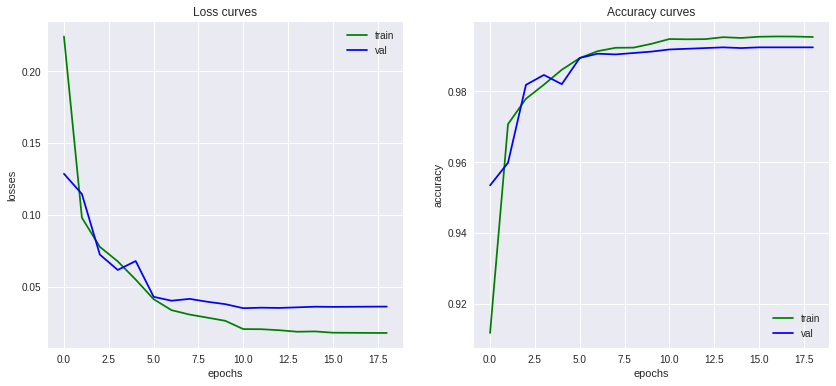

('n_min_valid_set', 128)
('n_test_set', 5000)
('shuffle_before_split', True)
('use_norm', True)
('batch_size', 128)
('trainer', 'YQ')
('max_epochs', 30)
('early_stopping', True)
('epoch_patience', 5)
('auto_load_best_after_train', True)
('auto_save_interval', 5)
('show_live_progress', True)
('best_acc_train', 0.995475)
('best_acc_val', 0.9924)
('time_elapsed', 938.423749923706)
('early_stopped', 14)
('epoch_passed', 19)

================== model11: Net5 ================== 
training model: Net5_0.5_0.0__YQ_11, lr: 0.001, weight_decay:0
shuffling train_valid_set before splitting... complete.
split train_valid_set to 40000 / 5000 samples
train_set size:40000, valid_set size:5000
's': auto saved, '*': best accuracy so far.
[Epoch  0/29 100.00% 0m50s] train loss: 0.2167 acc: 91.34%   val loss: 0.1018 acc: 97.14%   *
[Epoch  1/29 100.00% 0m50s] train loss: 0.0982 acc: 97.03%   val loss: 0.0664 acc: 98.26%   *
[Epoch  2/29 100.00% 0m49s] train loss: 0.0720 acc: 98.00%   val loss: 0.0746 acc: 

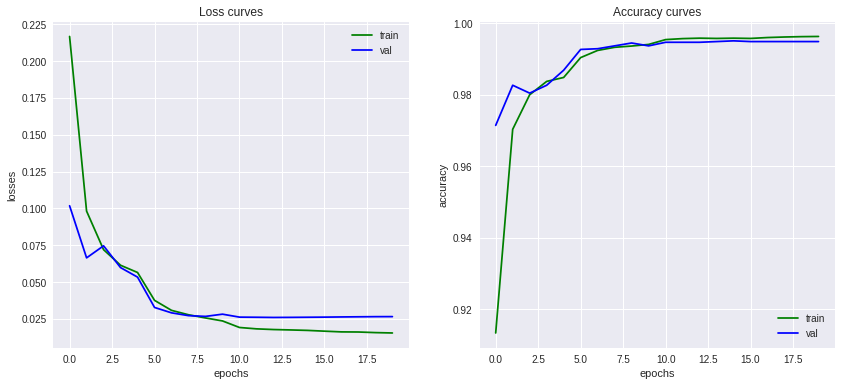

('n_min_valid_set', 128)
('n_test_set', 5000)
('shuffle_before_split', True)
('use_norm', True)
('batch_size', 128)
('trainer', 'YQ')
('max_epochs', 30)
('early_stopping', True)
('epoch_patience', 5)
('auto_load_best_after_train', True)
('auto_save_interval', 5)
('show_live_progress', True)
('best_acc_train', 0.996225)
('best_acc_val', 0.995)
('time_elapsed', 988.7064473628998)
('early_stopped', 15)
('epoch_passed', 20)

================== model12: Net5 ================== 
training model: Net5_0.5_0.0__YQ_12, lr: 0.001, weight_decay:0
shuffling train_valid_set before splitting... complete.
split train_valid_set to 40000 / 5000 samples
train_set size:40000, valid_set size:5000
's': auto saved, '*': best accuracy so far.
[Epoch  0/29 100.00% 0m50s] train loss: 0.2227 acc: 90.98%   val loss: 0.0958 acc: 97.14%   *
[Epoch  1/29 100.00% 0m49s] train loss: 0.0941 acc: 97.04%   val loss: 0.0766 acc: 98.04%   *
[Epoch  2/29 100.00% 0m49s] train loss: 0.0716 acc: 98.10%   val loss: 0.0598 acc: 

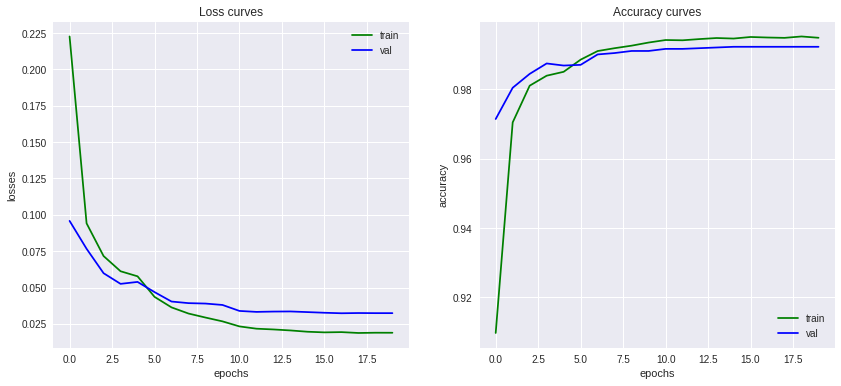

('n_min_valid_set', 128)
('n_test_set', 5000)
('shuffle_before_split', True)
('use_norm', True)
('batch_size', 128)
('trainer', 'YQ')
('max_epochs', 30)
('early_stopping', True)
('epoch_patience', 5)
('auto_load_best_after_train', True)
('auto_save_interval', 5)
('show_live_progress', True)
('best_acc_train', 0.995175)
('best_acc_val', 0.9922)
('time_elapsed', 986.0299928188324)
('early_stopped', 15)
('epoch_passed', 20)

================== model13: Net5 ================== 
training model: Net5_0.5_0.0__YQ_13, lr: 0.001, weight_decay:0
shuffling train_valid_set before splitting... complete.
split train_valid_set to 40000 / 5000 samples
train_set size:40000, valid_set size:5000
's': auto saved, '*': best accuracy so far.
[Epoch  0/29 100.00% 0m50s] train loss: 0.2288 acc: 90.63%   val loss: 0.1077 acc: 96.58%   *
[Epoch  1/29 100.00% 0m49s] train loss: 0.1024 acc: 96.84%   val loss: 0.0930 acc: 97.22%   *
[Epoch  2/29 100.00% 0m49s] train loss: 0.0782 acc: 97.78%   val loss: 0.0667 acc:

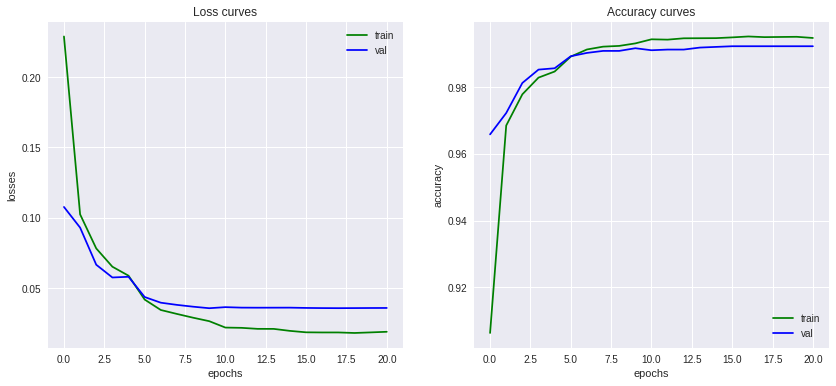

('n_min_valid_set', 128)
('n_test_set', 5000)
('shuffle_before_split', True)
('use_norm', True)
('batch_size', 128)
('trainer', 'YQ')
('max_epochs', 30)
('early_stopping', True)
('epoch_patience', 5)
('auto_load_best_after_train', True)
('auto_save_interval', 5)
('show_live_progress', True)
('best_acc_train', 0.995125)
('best_acc_val', 0.9922)
('time_elapsed', 1036.3160514831543)
('early_stopped', 16)
('epoch_passed', 21)

================== model14: Net5 ================== 
training model: Net5_0.5_0.0__YQ_14, lr: 0.001, weight_decay:0
shuffling train_valid_set before splitting... complete.
split train_valid_set to 40000 / 5000 samples
train_set size:40000, valid_set size:5000
's': auto saved, '*': best accuracy so far.
[Epoch  0/29 100.00% 0m50s] train loss: 0.2102 acc: 91.67%   val loss: 0.0838 acc: 97.48%   *
[Epoch  1/29 100.00% 0m50s] train loss: 0.0888 acc: 97.36%   val loss: 0.0725 acc: 98.06%   *
[Epoch  2/29 100.00% 0m49s] train loss: 0.0727 acc: 98.07%   val loss: 0.0664 acc

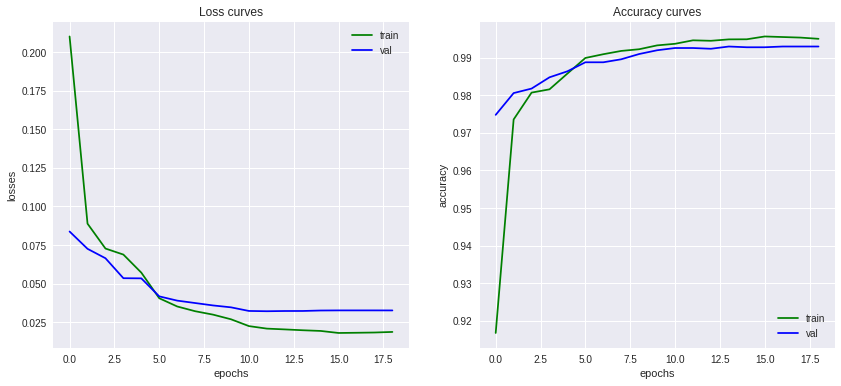

('n_min_valid_set', 128)
('n_test_set', 5000)
('shuffle_before_split', True)
('use_norm', True)
('batch_size', 128)
('trainer', 'YQ')
('max_epochs', 30)
('early_stopping', True)
('epoch_patience', 5)
('auto_load_best_after_train', True)
('auto_save_interval', 5)
('show_live_progress', True)
('best_acc_train', 0.995675)
('best_acc_val', 0.993)
('time_elapsed', 938.8093650341034)
('early_stopped', 14)
('epoch_passed', 19)


In [15]:
n_class = 2
NEW_IMG_SIZE = (28, 28)

models = []
for i in range(15):
    models.append(Net5(p_fc = 0.5, channels = [32, 64, 128, 128, 128]))
    
caches = []

train_config = {
    "n_min_valid_set": 128,
    "n_test_set": 5000,
    "shuffle_before_split": True,
    "use_norm": True, # use_normalization,
    "batch_size": 128,
    "trainer": "YQ",
    "max_epochs": 30,
    "early_stopping": True,
    "epoch_patience": 5,
    "auto_load_best_after_train": True,
    "auto_save_interval": 5,
    "show_live_progress": True
}

debug("global training configuration: ")
for item in train_config.items():
    debug(item)


# apply different train / val split for different models
n_valid_sample = [5000] * len(models)
# or set different number of validate set like:
# n_valid_sample = [1500, 1000, 500, 2000, 1500... ] 
#[15000, 500, 500, 500, 500, 1000, 1000, 1000, 1000, 1000]
# minimal smple number for validating

# all training samples are in total_set
total_set = data
#total_set = np.concatenate((X_resized, image_labels.reshape(-1, 1)), axis = 1)

if train_config["shuffle_before_split"]:
    np.random.shuffle(total_set) # not need this?

# split the total dataset to train_valid and test set.
n_total_set = total_set.shape[0]
test_start = n_total_set - train_config["n_test_set"]

# load pre-processed train data as a whole train_valid_test set.
debug("reserve {} samples for testing".format(train_config["n_test_set"]))
train_valid_set = total_set[:n_total_set - train_config["n_test_set"],:]
test_set = None
if train_config["n_test_set"] > 0:
    test_set = total_set[n_total_set - train_config["n_test_set"]:,:]
    
# training each model
for i, model in enumerate(models):
    
    debug("\n================== model{}: {} ================== ".format(
        i, type(model).__name__))
 
    hp_params = {
        "model_name": type(model).__name__,
        "lr": 1e-3,
        "weight_decay": 0,
        "n_test_set": train_config["n_test_set"],
        "dropout_p": model.dropout_p,
        "dropout_conv_p": model.dropout_conv_p,
    }
    
    # loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = hp_params["lr"], 
                           weight_decay = hp_params["weight_decay"])
    #scheduler = lr_scheduler.StepLR(optimizer, 
    #                                step_size = 5, 
    #                                gamma = 0.5)

    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    # Decay lr: first 10 epochs: 1e-3, last 10 epochs 1e-5, in middle: 1e-4
    scheduler = lr_scheduler.MultiStepLR(
        optimizer,  
        milestones = [5,10,15,train_config["max_epochs"]-5], 
        gamma = 0.1)
    
    suffix = "_" + train_config["trainer"] + "_" + str(i)
    debug('training model: {}, lr: {}, weight_decay:{}'.format(
        model.get_name(suffix), 
        optimizer.param_groups[0]['lr'], 
        optimizer.param_groups[0]['weight_decay']))
    
    if train_config["shuffle_before_split"]:
        debug("shuffling train_valid_set before splitting... ", end = "")
        np.random.shuffle(train_valid_set)
        debug("complete.")
    
    # reload train_valid_set from total_set
    train_valid_set = total_set[:n_total_set - train_config["n_test_set"],:]
    
    # split dataset to train / valid sets
    n_train_valid_set = train_valid_set.shape[0]
    cur_valid_sample = max(n_valid_sample[i], train_config["n_min_valid_set"])
    hp_params["n_valid_set"] = cur_valid_sample

    train_set = train_valid_set[0: -cur_valid_sample,:]
    valid_set = train_valid_set[-cur_valid_sample: ,:]
 
    debug("split train_valid_set to {} / {} samples".format(
        n_train_valid_set - cur_valid_sample, cur_valid_sample))
    
    #view_data_distribution(valid_set[:,-1], "valid_set", int_to_label)

    
    # data augmentation on training set
    n_train_set = train_set.shape[0]
    hp_params["n_train_set"] = n_train_set
    
    np.random.shuffle(train_set)
    #view_data_distribution(train_set[:,-1], "train_set", int_to_label)
    
    # build new train_valid_set by merging train set with valid set
    train_valid_set = np.concatenate((train_set, valid_set), axis = 0)
    
    # set model save path
    best_model_path = './models/best_model_' + model.get_name(suffix)
    auto_save_path = './models/auto_save_' + model.get_name(suffix)
    
    # pre-trained model from file
    # careful: this may cause model saw samples in validating set.
    # must NOT use pre-trained model if whole train / valid set si shuffled
    #model = load_model(model, best_model_path, auto_save_path)
    
    model.to(device)
    model.train()
    
    debug("train_set size:{}, valid_set size:{}".format(
        hp_params["n_train_set"], hp_params["n_valid_set"]))
    
    # perform training process
    model, loss, accuracies, train_result = train_model(
        model, 
        train_valid_set,
        criterion, 
        optimizer, 
        n_valid_sample = cur_valid_sample,
        scheduler = scheduler, 
        max_epochs = train_config["max_epochs"],
        early_stopping = train_config["early_stopping"],
        epoch_patience = train_config["epoch_patience"],
        auto_load_best_after_train = train_config["auto_load_best_after_train"],
        auto_save_path = auto_save_path, 
        best_model_path = best_model_path,
        auto_save_interval = train_config["auto_save_interval"],
        batch_size = train_config["batch_size"],
        show_live_progress = train_config["show_live_progress"]
    )
    caches.append(train_result)
    
    show_learning_curve(loss, accuracies)  
    for item in train_config.items():
        debug(item)
    for item in train_result.items():
        debug(item)

### 1.6 Performance of models on reserved testing dataset
We also implemented some methods to make prediction and bagging.

In [0]:
def predict(model, test_X):
    """predict using a model on a dataset(test_X)
    params
        model: nn.Module
        test_X: dataset, narray (n_size, n_feature)
    returns
        predict_labels: prediction, list [n_size]
    """
    since = time.time()
    model.to(device)
    try:
        model.eval()   # Set model to evaluate mode
    except:
        pass
    predict_labels = []
    # Iterate over data.
    i = 0
    total = len(test_X)
    test_data = dataloader(phase = 'test', data_source = test_X, 
                           img_size = NEW_IMG_SIZE)
    for batch_inputs in test_data:
        #debug(batch_inputs.shape)
        batch_inputs = batch_inputs.to(device)
        with torch.set_grad_enabled(False):
            batch_outputs = model(batch_inputs)
            batch_predict = torch.argmax(batch_outputs, dim = 1)
            batch_predict = batch_predict.cpu().numpy().tolist()
            predict_labels.extend(batch_predict)
            i += batch_inputs.size(0)
            print_progress(i / total)
    return predict_labels


def predicts_from_models(models, test_X):
    """return an ensemble predicts of all models on test_X
    params
        models: list [model]
        test_X: test set, narray (n_samples, n_features)
    returns
        predicts: narray (n_samples, len(models))
    """
    n_models = len(models)
    n_samples = test_X.shape[0]
    predicts = np.zeros((n_samples, n_models))
    for i, model in enumerate(models):
        predicts[:,i] = np.array(predict(model, test_X)).reshape(-1, )
    
    return predicts


def bagging(all_predicts):
    """giving a bagging predict based on all_predicts
    params
        all_predicts: narray (n_samples, n_models)
    returns
        voted_predict: list, 
    """
    n_samples, n_models = all_predicts.shape
    voted_predict = [None] * n_samples
    for i in range(n_samples):
        voted_predict[i] = np.argmax(np.bincount(all_predicts[i].astype(int)))
    return voted_predict


def bagging_from_models(models, test_X):
    """ensemble predic using bagging
    params
        models: list of model of nn.Module, [nn.Module]
        test_X: dataset, narray (n_size, n_feature)
    returns
        voted_predicted: prediction, list [n_size]
        predicts: predicts by all models, narray [n_size, len(models)]
    """
    predicts = predicts_from_models(models, test_X)
    voted_predict = bagging(predicts)   
    return voted_predict, predicts
    

def analysis_predict(true_labels, predict_labels, n_class = 31, 
                     int_to_label = None):
    """give an averate accuracy, show accuracies in each class.
    you can switch the values of the two parameters to see difference output
    params
        true_labels: narray (-1, ) or (-1, 1)
        predict_labels: narray (-1, ) or (-1, 1)
    returns
        average_accuracy
    """
    debug("Size: {}".format(len(true_labels)))
    class_correct = [0 for _ in range(n_class)]
    class_total = [0 for _ in range(n_class)]
    for i in range(len(predict_labels)):
        label_int = int(true_labels[i])
        class_correct[label_int] += (predict_labels[i] == label_int)
        class_total[label_int] += 1
        
    average_accuracy = sum(class_correct) / sum(class_total)
    print("Average accuracy: {:.2%}".format(average_accuracy))

    print("-"*32)
    for i in range(n_class):
        s = int_to_label[i] if int_to_label else str(i)
        print("Accuracy of {:>12s}: {:.2%}({}/{})".format(
            str(i), class_correct[i] / class_total[i], 
            class_correct[i], class_total[i]))

    return average_accuracy

In [17]:
voted_predict, all_predicts = bagging_from_models(models, test_set[:,:-1])

progress:100.00%

In [18]:
analysis_predict(test_set[:,-1], voted_predict, n_class = 2)

Size: 5000
Average accuracy: 99.28%
--------------------------------
Accuracy of            0: 98.55%(2451/2487)
Accuracy of            1: 100.00%(2513/2513)


0.9928

In [19]:
for i in range(all_predicts.shape[1]):
    analysis_predict(test_set[:,-1], all_predicts[:,i], n_class = 2)
    print("")

Size: 5000
Average accuracy: 99.26%
--------------------------------
Accuracy of            0: 98.63%(2453/2487)
Accuracy of            1: 99.88%(2510/2513)

Size: 5000
Average accuracy: 99.18%
--------------------------------
Accuracy of            0: 98.39%(2447/2487)
Accuracy of            1: 99.96%(2512/2513)

Size: 5000
Average accuracy: 99.24%
--------------------------------
Accuracy of            0: 98.47%(2449/2487)
Accuracy of            1: 100.00%(2513/2513)

Size: 5000
Average accuracy: 99.16%
--------------------------------
Accuracy of            0: 98.39%(2447/2487)
Accuracy of            1: 99.92%(2511/2513)

Size: 5000
Average accuracy: 99.26%
--------------------------------
Accuracy of            0: 98.55%(2451/2487)
Accuracy of            1: 99.96%(2512/2513)

Size: 5000
Average accuracy: 99.20%
--------------------------------
Accuracy of            0: 98.39%(2447/2487)
Accuracy of            1: 100.00%(2513/2513)

Size: 5000
Average accuracy: 99.24%
--------------

### 1.7 Predict on Test Dataset

In this section, we can either use the models created during the training precedure or recreate the models and load their parameters from file paths. Skip the next 3 cells if the trained 12 models are alive; otherwise, run the next 3 cells to load models from files.

In [16]:
n_class = 2
NEW_IMG_SIZE = (28, 28)

models = []
for i in range(15):
    models.append(Net5(p_fc = 0.5, channels = [32, 64, 128, 128, 128]))
    

'\nmodels = [\n    Net5(p_fc = 0.5, channels = [32, 64, 128, 128, 128]),\n    Net5(p_fc = 0.5, channels = [16, 32, 64, 64, 64]),\n    Net5(p_fc = 0.5, channels = [8, 16, 32, 64, 64]),\n    Net5(p_fc = 0.5, channels = [8, 16, 32, 64, 128]),\n    \n    Net5(p_fc = 0.6, channels = [32, 64, 128, 128, 128]),\n    Net5(p_fc = 0.6, channels = [16, 32, 64, 64, 64]),\n    Net5(p_fc = 0.6, channels = [8, 16, 32, 64, 64]),\n    Net5(p_fc = 0.6, channels = [8, 16, 32, 64, 128]),\n    \n    Net5(p_fc = 0.4, channels = [32, 64, 128, 128, 128]),\n    Net5(p_fc = 0.4, channels = [16, 32, 64, 64, 64]),\n    Net5(p_fc = 0.4, channels = [8, 16, 32, 64, 64]),\n    Net5(p_fc = 0.4, channels = [8, 16, 32, 64, 128]),    \n]\n'

In [0]:
def load_model(model, 
               best_model_path = None, 
               auto_save_path = None,
               best_model_first = True,
               ext = "",
              ):
    """load a pre-trained model from a file path
    params
        model: model, nn.Module
        laod_best_model_first: Bool, if True, try first to load the model with
            parameters has best performance on validating set
        best_model_path: str
        auto_save_path: str
    return
        model: with pre_trained parameters loaded, if failed to load either
            parameters, return the model as it was.
    """

    if best_model_path is None:
        best_model_path = './models/best_model_' + model.get_name(ext)
    if auto_save_path is None:
        auto_save_path = './models/auto_save_' + model.get_name(ext)
    
    file_paths = [auto_save_path, best_model_path]
    if best_model_first:
        file_paths = [best_model_path, auto_save_path]

    try:
        debug("loading model from: '{}'... ".format(file_paths[0]), end=" ")
        model.load_state_dict(torch.load(file_paths[0]))
        debug("successful.")
    except:
        try:
            debug("failure.")
            debug("loading model from: '{}'... ".format(file_paths[1]), end = " ")
            model.load_state_dict(torch.load(file_paths[1]))
            debug("successful")
        except:
            debug("failure.\nusing new model parameters.")

    model = model.to(device)
    return model

In [18]:
for i, model in enumerate(models):
    model = load_model(model, None, None, True, ext = "_YQ_" + str(i))

loading model from: './models/best_model_Net5_0.5_0.0__YQ_0'...  successful.
loading model from: './models/best_model_Net5_0.5_0.0__YQ_1'...  successful.
loading model from: './models/best_model_Net5_0.5_0.0__YQ_2'...  successful.
loading model from: './models/best_model_Net5_0.5_0.0__YQ_3'...  successful.
loading model from: './models/best_model_Net5_0.5_0.0__YQ_4'...  successful.
loading model from: './models/best_model_Net5_0.5_0.0__YQ_5'...  successful.
loading model from: './models/best_model_Net5_0.5_0.0__YQ_6'...  successful.
loading model from: './models/best_model_Net5_0.5_0.0__YQ_7'...  successful.
loading model from: './models/best_model_Net5_0.5_0.0__YQ_8'...  successful.
loading model from: './models/best_model_Net5_0.5_0.0__YQ_9'...  successful.
loading model from: './models/best_model_Net5_0.5_0.0__YQ_10'...  successful.
loading model from: './models/best_model_Net5_0.5_0.0__YQ_11'...  successful.
loading model from: './models/best_model_Net5_0.5_0.0__YQ_12'...  successf

We load test dataset from a file. Test dataset has 8000 examples, each containing a vector with 784 dimensions, without a label.

In [0]:
test_data = np.loadtxt("PATCH_test.amat")
# test_X, test_y = test_data[:,:-1], test_data[:, -1]
test_X = test_data

In [20]:
print(test_X.shape)#, test_y.shape)

(8000, 784)


We use the following code to make a bagging prediction on test dataset

In [21]:
bagging_predict, all_predicts = bagging_from_models(models, test_data)

progress:100.00%

Finally, we export our prediction to a csv file. In the csv file, there are altegother 8000 lines; each line has only one integer indicating the predicted class of the corresponding line of example in test dataset.

In [0]:
import csv

def predicts_to_csv(predicts, file_path):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter = ',')
        #writer.writerow(("Id", "Category"))
        for i, label in enumerate(predicts):
            writer.writerow((predicts[i], ))
            #writer.writerow((i, int_to_label[predicts[i]]))
    debug(" save csv files to: {}".format(file_path))

In [32]:
current_model_name = "final_predict"
bagging_file_path = './submissions/' + current_model_name + ".csv"
predicts_to_csv(bagging_predict, bagging_file_path) 

 save csv files to: ./submissions/final_predict.csv


We can also save all 12 models' predictions:

In [24]:
for i, model in enumerate(models):
    file_path = "./submissions/" + model.get_name("YQ") + "_" + str(i) + ".csv"
    pred = predict(model, test_X)
    predicts_to_csv(pred, file_path)

progress:100.00% save csv files to: ./submissions/Net5_0.5_0.0_YQ_0.csv
progress:100.00% save csv files to: ./submissions/Net5_0.5_0.0_YQ_1.csv
progress:100.00% save csv files to: ./submissions/Net5_0.5_0.0_YQ_2.csv
progress:100.00% save csv files to: ./submissions/Net5_0.5_0.0_YQ_3.csv
progress:100.00% save csv files to: ./submissions/Net5_0.5_0.0_YQ_4.csv
progress:100.00% save csv files to: ./submissions/Net5_0.5_0.0_YQ_5.csv
progress:100.00% save csv files to: ./submissions/Net5_0.5_0.0_YQ_6.csv
progress:100.00% save csv files to: ./submissions/Net5_0.5_0.0_YQ_7.csv
progress:100.00% save csv files to: ./submissions/Net5_0.5_0.0_YQ_8.csv
progress:100.00% save csv files to: ./submissions/Net5_0.5_0.0_YQ_9.csv
progress:100.00% save csv files to: ./submissions/Net5_0.5_0.0_YQ_10.csv
progress:100.00% save csv files to: ./submissions/Net5_0.5_0.0_YQ_11.csv
progress:100.00% save csv files to: ./submissions/Net5_0.5_0.0_YQ_12.csv
progress:100.00% save csv files to: ./submissions/Net5_0.5_0.

The first 1000 lines of the csv file are:

In [33]:
test_predict = np.loadtxt(bagging_file_path)
print(test_predict[0:1000])

[0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0.
 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.

**The end of Question 1**
<hr>

## 2. Question 2

**Answer**

### MapReduce - distribute method

For solving below problems, we considering adopting MapReduce method which could be used to run the job parrally on these 300 servers. With this method, we could redundantly distribute files by block (HDFS, Hadoop Distributed File System), distribute the calculation, maximize the proximity of computing units and disks, with MapReduce parallel programming paradigm.

This method includes two phases: Map and Reduce. Before sending data to the mapper, first convert it into key-value pairs. Because mapper only key-value pairs of data. Each phase has key-value as input and output.

#### - Map: (k, v) -> <k', v'>:  In parallel, extract relevant information from each block. 
Take a key-value pair and generate a set of key-value pairs.

#### - Reduce: (k', <v'>) -> <k', v''>: Join, combine, summarize partial results

All values v' with the same key K' are grouped together.

There is a call to a reduction function for each unique key K

### 2.1 Find the nearest 1000 pairs of twin stars (Euclidean distance from the position)

We would use MapReduce to solve this problem. From the data, we could know: luminance, physical_features, coordinates: (x,y,z)

Let's give the definition of twin stars: their age and their common properties suggest that they were born together, before dispersing in the Universe. We would use the luminance and physical_features to find them.

__Step 1:__ Map: {star_id: luminance, physical_features}

__Step 2:__ Reduce: with same luminance and physical_features, we group them to one pair star. {pair_star_id: star_id_1, star_id_2}

In our case, the location of each star is already known in the data set，let us give
$p = (p_x, p_y, p_z)$ and $q = (q_x, q_y, q_z)$ are two points in Euclidean n-space, then the distance (d) from p to q, or from q to p is given by:
$$ d(p,q) = d(q,p) = \sqrt{(q_x-p_x)^2 + (q_y-p_y)^2 + (q_z-p_z)^2}$$

__Step 3:__ Calculate the distance between each twin star with their coordinates: (x,y,z)

__Step 4:__ Map again with the distance: {pair_star_id: distance} sorted by distance acsending

__Step 5:__ Select firth 1000th pair_star from the dictionary and write the resulting pairs in files

All phases are distributed in many tasks

### 2.2 Count how many stars there are in each category.

Here we could use Map-Reduce method to sort the star category in each server, then combine and count the stars there are in each category.

In [0]:
def Map(key, values):
// key: star_id; value: category
    for each star s in server[i]:
        emit(category, i)

def reduce(key, values):
// key: category; value: an iterator over counts
    result = 0
    for each count v in values:
        result += v
    emit(key, result)

### 2.3 Produce a classifier that, given the feature vector (22 real numbers), predicts the category of the star.

It's a classification problem. Now the task is to predict the category of the star with the given feature vector (22 real numbers). We would consider below processing in generating a Random Forest classifier with large scale data:

__Step 1:__ Input data stored in distributed file system and divided into contiguous blocks.

__Step 2:__ Map: input data with {label: 22 features}

__Step 3:__ Selected random features and train a decision tree in each server

__Step 4:__ Reduce: For unseen data, predict the category paralle in each server 

__Step 5:__ Finally give a majority vote to provide the final prediction.

<hr>

## 3. Question 3

Expliquez en détail comment utiliser un classifieur binaire, capable d'apprendre à effectuer la classification de deux catégories, pour réaliser la classification dans un contexte ou plusieurs catégories doivent être distinguées. Considérez le cas à 3, 25, 12500 catégories et faite le contraste entre les différentes approches étudiées et le nombre de catégories.

**Answer**


In data science and machine learning, classification is a task for identifying to which of a set of categories a new observation belongs.
Classification tasks are widely used in real world applications. Many of them involve more than two classes, that is multi-class problem. Usually, it is easier to build a classifier to distinguish only between two classes than to consider more than two classes in a problem, since the decision boundaries in the former case can be simpler. This is why binarization techniques have come up to deal with multi-class problems by dividing the original problem into easier to solve binary classification problems that are faced by binary classifiers. These classifiers are usually referred to as base learners or base classifiers of the system.

**Approaches**

There are many methods to reduce a multiclass problem to multiple binary classification problems. For all of these methods, after the binary classification problems have been solved, then we need to combine the results of binary classifiers in some way to get a final result of multi-class problem.

$\bullet $**One-vs-All (OVA)**

OVA strategy trains a single classifier for each class. A proper technique can be used for building binary classifiers (e.g., Regularized Least Squares Classification, SVM) then we build $n$ different binary classifiers. For the $i$th classifier, all the points in class $i$ are the positive examples and all the points not in class $i$ are the negative examples. Suppose $f_i$ is the $i$th classifier and $f_i(\mathrm{x})$ is the score of $i$th classifier with an input $\mathrm{x}$.

Then, any multi-class problem can resolved with following equation:

$f(\mathrm{x}) = \underset{i}{\mathrm{arg \max}} \ f_i(\mathrm{x})$

It return class index $i$ which has the highest score with the input $\mathrm{x}$.

$\bullet $**One-vs-One(OVO)**

It is also called All-Pairs or All-vs-All classification. This method consists in fitting one classifier per class pair.

OVO builds ${n(n-1)} \over 2$ classifiers, one classifier to distinguish each pair of classes $i$ and $j$. Let $f_{ij}$ be the classifier where class $i$ were positive examples and class $j$ were negative.

Then, we can classify a multi-class problem with the equation:

$f(\mathrm{x}) = \underset{i}{\mathrm{arg \max}} \ \lgroup {\sum_{j}^{}f_{ij}(\mathrm{x})} \rgroup $.

The class which received the most votes is selected.

**Approach comparison**

The selection between OVA and OVO is mainly computational. Since OVO requires ${n(n-1)} \over 2$ classifiers, on the other hand, OVA only needs $n$ classifiers.

Considering cases with 3, 25 and 12500 categories, we can get following contrast in a table by quantifying complexity of the two approaches with number of classifiers.

| #Class | OVA |  OVO |
|----------|:--------:|--------:|
|     3    |     3   |    3   |
|     25  |    25  |  300 |
| 12500 | 12500 | 78118750 |

So OVO is usually slower than OVA, due to its $O(n^2)$ complexity. Especially when the number of classes are very huge, we would always prefer to use OVA.
<hr>

## 4. Question 4

Faites une analyse détaillée et exhaustive des patrons existants dans le jeu de données
adulte. Il est possible que le regroupement de valeurs pour certaines caractéristiques
donne des résultat intéressant. Vous devez aussi, s’il y a lieux, discuter de l’aspect
éthique concernant l’utilisation des patrons obtenus.

**Answer**

### 4.1 Loading Adult Income Data

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

In [0]:
trainset_path = 'adult.data'
names = [
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"]

train_df = pd.read_table(trainset_path, sep = ', ', names = names, engine = 'python', na_values = "?")

In [38]:
print(train_df.shape)
train_df.head(10)

(32561, 15)


,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


### 4.2 Categorizing Features of Continuous Variables

In the dataset, there are 6 features which accept continuous values; they are: 'Ages', 'fnlwgt', 'Education-Num', 'Capital Gain', 'Capital Loss', 'Hours per week'. We noticed that feature 'Education-Num' and another categorical feature: 'Education' are redundant, so we remove the feature 'Education-Num'. For the rest 5 features, we categorize them so as to reduce the product numbers and to find meaningful patrons.

To categorize an continuous feature, we first observe their basic statistic information using method `statistics`, then make a category list by using method `int2categorical` and replace the original value with catogorized value by using method `categorize`.

If we use market model to describe the dataset, each example in the dataset represents a transaction or a history record; value of a feature represents a product. Different from standard market model, same values in in different features represent different products. So we need to assign different catogorized name to the same values in different features. In method `int2categorial`, we use a parameter `prefix` to differentiate the same values in different features.

Here are the methods we implemented:

In [0]:
def int2categorical(values: list = None, prefix = ""):
    if values is None or len(values) == 0:
        return []
    categories = []
    if len(values) > 1:
        for i in range(len(values)-1):
            categories.append(prefix + "{}-{}".format(values[i], values[i+1]))
    return categories

def statistics(column_label: str, df: pd.DataFrame):
    df[column_label].hist()
    print(df[column_label].describe())
    
def categorize(column_label, values, categories, df):
    new_col_label = column_label # + "_cat"
    df[new_col_label] = pd.cut(df[column_label], values, right = False, labels = categories)   

We remove the feature 'Education-Num'.

In [0]:
del train_df["Education-Num"]

For the other 5 continuous features, we categorize them.

**Age**

count    32561.000000
mean        38.581647
std         13.640433
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: Age, dtype: float64


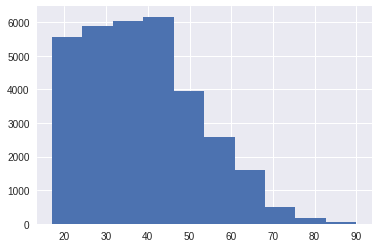

In [41]:
label = "Age"
statistics(label, train_df)

In [0]:
values = [0, 18, 30, 40, 50, 60, 70, 80, 90, 100]
labels = int2categorical(values, prefix = "age_")
categorize(label, values, labels, train_df)

**fnlwgt**

count    3.256100e+04
mean     1.897784e+05
std      1.055500e+05
min      1.228500e+04
25%      1.178270e+05
50%      1.783560e+05
75%      2.370510e+05
max      1.484705e+06
Name: fnlwgt, dtype: float64


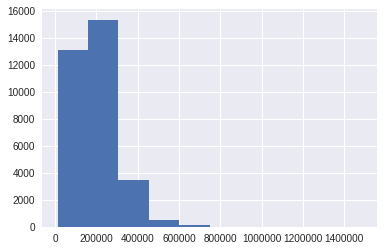

In [43]:
label = "fnlwgt"
statistics(label, train_df)

In [0]:
values = np.arange(0, 1600000, 100000)
labels = int2categorical(values, prefix = "fnlwgt_")
categorize(label, values, labels, train_df)

**Capital Gain**

count    32561.000000
mean      1077.648844
std       7385.292085
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: Capital Gain, dtype: float64


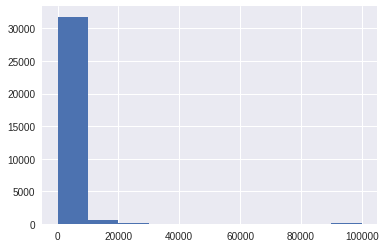

In [45]:
label = "Capital Gain"
statistics(label, train_df)

In [0]:
values = [0, 1, 10, 100, 1000, 10000, 100000]
labels = int2categorical(values, prefix = "CG_")
categorize(label, values, labels, train_df)

**Capital Loss**

count    32561.000000
mean        87.303830
std        402.960219
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: Capital Loss, dtype: float64


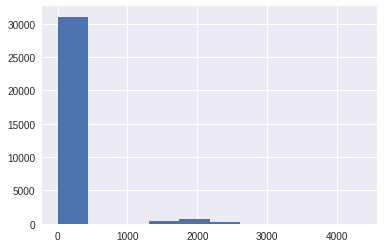

In [47]:
label = "Capital Loss"
statistics(label, train_df)

In [0]:
values = [0, 1, 10, 100, 1000, 10000, 100000]
labels = int2categorical(values, prefix = "CL_")
categorize(label, values, labels, train_df)

**Hours per week**

count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: Hours per week, dtype: float64


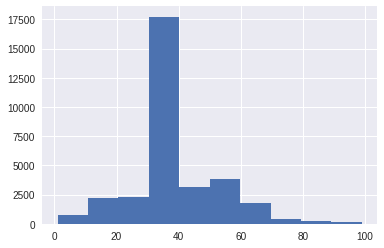

In [49]:
label = "Hours per week"
statistics(label, train_df)

In [0]:
values = [i for i in range(0, 100, 10)]
labels = int2categorical(values, prefix = "hpw_")
categorize(label, values, labels, train_df)

After categorizing, the data changes to the following forms(the first 20 examples):

In [51]:
train_df.head(20)

,Age,Workclass,fnlwgt,Education,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,age_30-40,State-gov,fnlwgt_0-100000,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,CG_1000-10000,CL_0-1,hpw_40-50,United-States,<=50K
1,age_50-60,Self-emp-not-inc,fnlwgt_0-100000,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,CG_0-1,CL_0-1,hpw_10-20,United-States,<=50K
2,age_30-40,Private,fnlwgt_200000-300000,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,CG_0-1,CL_0-1,hpw_40-50,United-States,<=50K
3,age_50-60,Private,fnlwgt_200000-300000,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,CG_0-1,CL_0-1,hpw_40-50,United-States,<=50K
4,age_18-30,Private,fnlwgt_300000-400000,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,CG_0-1,CL_0-1,hpw_40-50,Cuba,<=50K
5,age_30-40,Private,fnlwgt_200000-300000,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,CG_0-1,CL_0-1,hpw_40-50,United-States,<=50K
6,age_40-50,Private,fnlwgt_100000-200000,9th,Married-spouse-absent,Other-service,Not-in-family,Black,Female,CG_0-1,CL_0-1,hpw_10-20,Jamaica,<=50K
7,age_50-60,Self-emp-not-inc,fnlwgt_200000-300000,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,CG_0-1,CL_0-1,hpw_40-50,United-States,>50K
8,age_30-40,Private,fnlwgt_0-100000,Masters,Never-married,Prof-specialty,Not-in-family,White,Female,CG_10000-100000,CL_0-1,hpw_50-60,United-States,>50K
9,age_40-50,Private,fnlwgt_100000-200000,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,CG_1000-10000,CL_0-1,hpw_40-50,United-States,>50K


### 4.3 importing Frequent Pattern-Tree from Demo8

To find the frequent itemsets in the datasets, we use the algorithm: frequent patter tree. The class `FP_Tree` is implemented in Demo8; here we just use the class. We create a file: `fp_tree.py` containing the implementation of the class and put the file in current directory. 

In [0]:
sys.path.append("/content/drive/My Drive/Colab Notebooks/IFT6758/TP2/")
from fp_tree import FP_Tree

### 4.4 Finding the frequent itemsets

Before using the class `FP_Tree` to find the frequent itemsets, we need first to construct the market from the history, which is the dataset, and to compute the frequent of each product in the dataset. These can be done by the following codes.

In [0]:
freq = {}
history = []
market = {}
idx = 0

for i, row in train_df.iterrows(): 
    list_row = row.tolist() # from series to list
    history.append(list_row) 
   
    for product in list_row:
        if product not in market:
            market[product] = idx
            freq[idx] = 1
            idx += 1
        else:
            freq[market[product]] += 1
            
            
market_inv = {}
for key, value in market.items():
    market_inv[value] = key            

Let's see how many products(different values) in the whole datasets:

In [70]:
print(len(market))

142


Let's see the frequent of each product:

In [71]:
def show_freq(market_inv, freq, s = 0):
    print("{:<30} {}".format("Product", "Freq"))
    print("-"*36)
    num = 0
    for key in freq:
        if freq[key] >= s:
            print("{:<30} {}".format(market_inv[key], freq[key]))
            num += 1
    print("-"*36)
    print("total: {} products".format(num))
    
show_freq(market_inv, freq, s = 0)        

Product                        Freq
------------------------------------
age_30-40                      8613
State-gov                      1298
fnlwgt_0-100000                5670
Bachelors                      5355
Never-married                  10683
Adm-clerical                   3770
Not-in-family                  8305
White                          27816
Male                           21790
CG_1000-10000                  1887
CL_0-1                         31042
hpw_40-50                      18336
United-States                  29170
<=50K                          24720
age_50-60                      4418
Self-emp-not-inc               2541
Married-civ-spouse             14976
Exec-managerial                4066
Husband                        13193
CG_0-1                         29849
hpw_10-20                      1246
Private                        22696
fnlwgt_200000-300000           7976
HS-grad                        10501
Divorced                       4443
Handlers-cleane

Let's see how many products exist when we set the frequent threshold `s` to `10000`.

In [72]:
show_freq(market_inv, freq, s = 10000)    

Product                        Freq
------------------------------------
Never-married                  10683
White                          27816
Male                           21790
CL_0-1                         31042
hpw_40-50                      18336
United-States                  29170
<=50K                          24720
Married-civ-spouse             14976
Husband                        13193
CG_0-1                         29849
Private                        22696
HS-grad                        10501
Female                         10771
fnlwgt_100000-200000           14503
------------------------------------
total: 14 products


We set the threshold `s = 10000` to build the Frequent Pattern Tree.

In [73]:
threshold = 10000
frequent_product = [k for k, v in freq.items() if v > threshold]
for id in frequent_product:
    print(market_inv[id], end = ", ")
print()

Never-married, White, Male, CL_0-1, hpw_40-50, United-States, <=50K, Married-civ-spouse, Husband, CG_0-1, Private, HS-grad, Female, fnlwgt_100000-200000, 


In [0]:
import graphviz
from graphviz import Digraph

In [0]:
def test(history, subset = 10):
    fp_tree = FP_Tree()

    for basket in history[:subset]:
        # on convertit les noms de produit en entier
        basket = [market[product] for product in basket if market[product] in frequent_product]
        # on trie les produits
        basket.sort()
        #on insère dans le trie un basket
        fp_tree.insert(basket)
    return fp_tree

As a pre-experiment, we use the first 10 transactions(examples) to show the FP tree built.

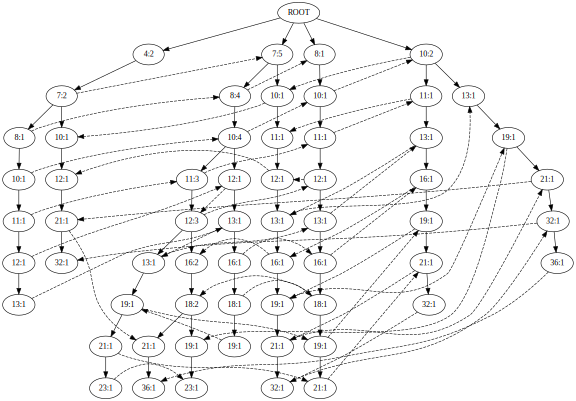

In [76]:
tree = test(history, 10)
tree.extract([], tree)
dot = tree.show(True)
graphviz.Source(dot)

Now, we build the tree based on whole dataset.

In [77]:
%%time
tree = test(history, None)

CPU times: user 363 ms, sys: 3.2 ms, total: 366 ms
Wall time: 370 ms


### 4.5 Interpretation of the Results

We print all frequent patterns when threshold is `10000`.

In [78]:
tree.extract([], tree, s = threshold)
tree.itemsets

[[4],
 [7],
 [7, 4],
 [8],
 [8, 4],
 [8, 7],
 [8, 7, 4],
 [10],
 [10, 4],
 [10, 7],
 [10, 7, 4],
 [10, 8],
 [10, 8, 4],
 [10, 8, 7],
 [10, 8, 7, 4],
 [11],
 [11, 4],
 [11, 7],
 [11, 7, 4],
 [11, 8],
 [11, 8, 4],
 [11, 8, 7],
 [11, 8, 7, 4],
 [11, 10],
 [11, 10, 4],
 [11, 10, 7],
 [11, 10, 7, 4],
 [11, 10, 8],
 [11, 10, 8, 4],
 [11, 10, 8, 7],
 [11, 10, 8, 7, 4],
 [12],
 [12, 4],
 [12, 7],
 [12, 7, 4],
 [12, 8],
 [12, 8, 4],
 [12, 8, 7],
 [12, 8, 7, 4],
 [12, 10],
 [12, 10, 4],
 [12, 10, 7],
 [12, 10, 7, 4],
 [12, 10, 8],
 [12, 10, 8, 4],
 [12, 10, 8, 7],
 [12, 10, 8, 7, 4],
 [12, 11],
 [12, 11, 4],
 [12, 11, 7],
 [12, 11, 7, 4],
 [12, 11, 8],
 [12, 11, 8, 4],
 [12, 11, 8, 7],
 [12, 11, 8, 7, 4],
 [12, 11, 10],
 [12, 11, 10, 4],
 [12, 11, 10, 7],
 [12, 11, 10, 7, 4],
 [12, 11, 10, 8],
 [12, 11, 10, 8, 4],
 [12, 11, 10, 8, 7],
 [12, 11, 10, 8, 7, 4],
 [13],
 [13, 4],
 [13, 7],
 [13, 7, 4],
 [13, 8],
 [13, 8, 4],
 [13, 8, 7],
 [13, 8, 7, 4],
 [13, 10],
 [13, 10, 4],
 [13, 10, 7],
 [13, 10

There are altogether 6655 frequent patterns when threshold is set `10000`.

In [79]:
print(len(tree.itemsets))

6655


Each of the 6655 patterns acquired is a list of integer; each integer represents the id of a product in the market. We can translate the ids to their names to have a clear understanding of the patterns found. The dictionary `market_inv` helps to do such translation.

We can also only show the frequent pattern with the list length no less than a certain value:

In [0]:
def show_frequent_products(length = 4):
    frequent_itemsets = []
    for itemset in tree.itemsets:
        if len(itemset) < length:
            continue
        freq_item = []
        for item in itemset:
            freq_item.append(market_inv[item])
        frequent_itemsets.append(freq_item)     
        print(freq_item)
    print("{} frequent pattern(s) with products length >= {}".format(
        len(frequent_itemsets), length))
    #return frequent_itemsets

When `length = 12`, we get the longest frequent pattern:

In [83]:
show_frequent_products(length = 12)

['fnlwgt_100000-200000', 'HS-grad', 'Private', 'CG_0-1', 'Husband', 'Married-civ-spouse', '<=50K', 'United-States', 'hpw_40-50', 'CL_0-1', 'Male', 'White']
1 frequent pattern(s) with products length >= 12


We can decrease the threshold to get more frequent patterns. The number of the frequent patterns will increase as the threhold decreases, and it will take more time to obtain these frequent patterns if the threshold decrease. In the report, we only examined the frequent patterns when threshold is `10000`, which is just a demostration.

### 4.6 Ethic Concerning on the Use of the Patterns Acquired


Having the most frequent patterns in Adult Income dataset, people can come to some interesting findings. According to the longest frequent pattern we found, for example, one may say that most U.S. white husbands have the income less than 50K. Although people cannot address one specific person from the pattern, it is still very crucial to protect the equality of certain groups and avoid discrimination. Such as group with the same occupation, marriage status, country/region, working hours per week, sex, race and income etc. From our point of view, researchers, companies or other organizations can never publish these patterns even if they legally use them to make profits or to do some other non profit affairs.



## The end of the report